In [1]:
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras import layers
from tensorflow import keras
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Load Data
(train_data, _train_label), (test_data, _test_label) = cifar100.load_data()

#Parse the number
train_data = train_data.astype('float32')
test_data = test_data.astype('float32')

#normalize data
train_data = train_data / 255
test_data = test_data / 255

train_label = to_categorical(_train_label)
test_label = to_categorical(_test_label)

169009152/169001437 [==============================] - 3s 0us/step


In [3]:
class Basic_Block(layers.Layer):
    def __init__(self, filter_num, stride_conv = False, stride = 1):
        super(Basic_Block, self).__init__()
        
        self.filter_num = filter_num
        
        self.conv1 = layers.Conv2D(self.filter_num, (3,3), strides = stride, padding = 'same' )
        self.batch1 = layers.BatchNormalization()
        self.relu = layers.Activation('relu')

        self.conv2 = layers.Conv2D(self.filter_num, (3,3), padding = 'same')
        self.batch2 = layers.BatchNormalization()

        if stride_conv:
            self.conv3 = layers.Conv2D(self.filter_num,(1,1), strides = stride)
        else:
            self.conv3 = None

    def call(self, inputs):
        out = self.conv1(inputs)
        #out = self.batch1(out)
        out = self.relu(out)

        out = self.conv2(out)
        #out = self.batch2(out)

        if self.conv3:
            inputs = self.conv3(inputs)

        out = layers.add([out, inputs])
        out = self.relu(out)

        return out

In [4]:
class ResNet(keras.Model):
    def __init__(self, num_classes = 100):
        super(ResNet, self).__init__()

        self.conv = layers.Conv2D(64, (3,3), strides = (1,1), padding = 'same')
        self.bn = layers.BatchNormalization()
        self.relu = layers.Activation('relu')
        self.maxpool = layers.MaxPool2D(pool_size = (2,2), padding = 'same')

        self.layer1 = self.build_layer(64, 2)
        self.layer2 = self.build_layer(128, 2, 2)
        self.layer3 = self.build_layer(256, 2, 2)
        self.layer4 = self.build_layer(512, 2, 2)

        self.avgpool = layers.AveragePooling2D()
        self.flatten = layers.Flatten()
        self.fc = layers.Dense(num_classes)

        self.activation = layers.Activation('softmax')
        self.dropout = layers.Dropout(0.1)

    def build_layer(self, filter_num, block, stride = 1):
        result = Sequential()

        result.add(Basic_Block(filter_num, stride_conv = True, stride = stride))

        for _ in range(1, block):
            result.add(Basic_Block(filter_num))

        return result

    def call(self, x):
        x = self.conv(x)
        #x = self.bn(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = self.flatten(x)
        #x = self.dropout(x)
        x = self.fc(x)
        x = self.activation(x)

        return x

In [5]:
def resnet18():
    return ResNet()

Epoch 1/20
1563/1563 [==============================] - 25s 16ms/step - loss: 4.4845 - accuracy: 0.0234
Epoch 2/20
1563/1563 [==============================] - 25s 16ms/step - loss: 3.9895 - accuracy: 0.0898
Epoch 3/20
1563/1563 [==============================] - 25s 16ms/step - loss: 3.6557 - accuracy: 0.1421
Epoch 4/20
1563/1563 [==============================] - 25s 16ms/step - loss: 3.4190 - accuracy: 0.1863
Epoch 5/20
1563/1563 [==============================] - 25s 16ms/step - loss: 3.2197 - accuracy: 0.2230
Epoch 6/20
1563/1563 [==============================] - 25s 16ms/step - loss: 3.0377 - accuracy: 0.2563
Epoch 7/20
1563/1563 [==============================] - 25s 16ms/step - loss: 2.8576 - accuracy: 0.2914
Epoch 8/20
1563/1563 [==============================] - 25s 16ms/step - loss: 2.6639 - accuracy: 0.3288
Epoch 9/20
1563/1563 [==============================] - 25s 16ms/step - loss: 2.4511 - accuracy: 0.3735
Epoch 10/20
1563/1563 [==============================] - 25s 16m

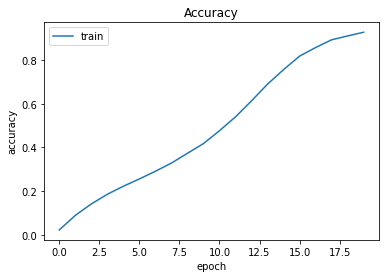

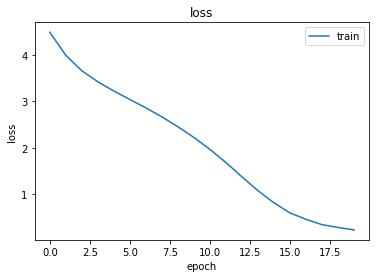

In [15]:
model = resnet18()
opt = keras.optimizers.SGD(learning_rate = 0.01)
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
es = EarlyStopping(monitor = 'loss', verbose = 1)
result = model.fit(train_data,train_label,epochs = 20, callbacks = [es])
predict = model.predict(test_data)
predict = np.argmax(predict, axis = 1)
#test_label = np.argmax(test_label, axis = 1)
print(classification_report(y_true = test_label, y_pred = predict))
plt.plot(result.history['accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'])
plt.show()

plt.plot(result.history['loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'])
plt.show()